# Import Packages and Load Datasets:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
train = train_raw.copy()
test = test_raw.copy()

In [3]:
train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [4]:
test.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban


In [5]:
train.drop_duplicates(keep='first', inplace=True)

In [6]:
train.drop('Loan_ID', axis=1, inplace=True)
test.drop('Loan_ID', axis=1, inplace=True)

# EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


In [8]:
for col in train.columns:
    print('Number of unique values in ' + col + ' are: ' +str(train[col].nunique()))

Number of unique values in Gender are: 2
Number of unique values in Married are: 2
Number of unique values in Dependents are: 4
Number of unique values in Education are: 2
Number of unique values in Self_Employed are: 2
Number of unique values in ApplicantIncome are: 505
Number of unique values in CoapplicantIncome are: 287
Number of unique values in LoanAmount are: 203
Number of unique values in Loan_Amount_Term are: 10
Number of unique values in Credit_History are: 2
Number of unique values in Property_Area are: 3
Number of unique values in Loan_Status are: 2


In [9]:
for item in [train, test]:
    print(item.isnull().sum())
    print('=================')

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


<AxesSubplot:>

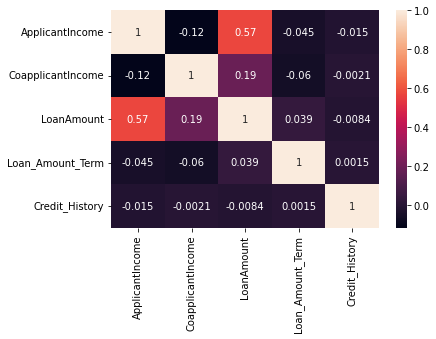

In [10]:
sns.heatmap(train.corr(), annot=True)

# Fill Missing Values

In [11]:
# Categorical Features
train['Gender'] = train['Gender'].ffill().bfill()
test['Gender'] = test['Gender'].ffill().bfill()
train['Married'].fillna('No', inplace=True)
train['Dependents'].fillna('0', inplace=True)
test['Dependents'].fillna('0', inplace=True)
train['Self_Employed'].fillna('No', inplace=True)
test['Self_Employed'].fillna('No', inplace=True)
train['Credit_History'].replace({1.:'Yes', 0.:'No'}, inplace=True)
test['Credit_History'].replace({1.:'Yes', 0.:'No'}, inplace=True)
train['Credit_History'].fillna('No', inplace=True)
test['Credit_History'].fillna('No', inplace=True)

In [12]:
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].median(), inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(), inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(), inplace=True)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    object 
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 62.4+ KB


# Split Data into Features and Target

In [14]:
X_train = train.drop('Loan_Status', axis=1)

In [15]:
y_train = train['Loan_Status'].replace({'Y': 1, 'N': 0})

In [16]:
X_test = test.copy()

# Data Encoding: pd.get_dummies

In [17]:
def df_encode(encode_data, encode_cols):
    encode_data = pd.get_dummies(encode_data)
    encode_data.astype('float64').dtypes
    return encode_data

In [18]:
encode_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

In [19]:
X_train_encoded = df_encode(X_train, encode_cols)
X_test_encoded = df_encode(X_test, encode_cols)

In [20]:
X_train_encoded.head(3)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_No,Credit_History_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,128.0,360.0,0,1,1,0,1,0,...,0,1,0,1,0,0,1,0,0,1
1,4583,1508.0,128.0,360.0,0,1,0,1,0,1,...,0,1,0,1,0,0,1,1,0,0
2,3000,0.0,66.0,360.0,0,1,0,1,1,0,...,0,1,0,0,1,0,1,0,0,1


In [21]:
X_test_encoded.head(3)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_No,Credit_History_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5720,0,110.0,360.0,0,1,0,1,1,0,...,0,1,0,1,0,0,1,0,0,1
1,3076,1500,126.0,360.0,0,1,0,1,0,1,...,0,1,0,1,0,0,1,0,0,1
2,5000,1800,208.0,360.0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,0,0,1


# Data Scaling with RobustScaler, MinMaxScaler, and StandardScaler

In [22]:
def scale_data(scaler, scale_data, scale_cols):
    if scaler=='RobustScaler':
        scale_data[scale_cols] = RobustScaler().fit_transform(scale_data[scale_cols])
    elif scaler=='MinMaxScaler':
        scale_data[scale_cols] = MinMaxScaler().fit_transform(scale_data[scale_cols])
    elif scaler=='StandardScaler':
        scale_data[scale_cols] = StandardScaler().fit_transform(scale_data[scale_cols])
    else: 
        print('Please use scaler value: RobustScaler, MinMaxScaler, or StandardScaler')
    
    return scale_data
        

In [23]:
X_train_scaled = scale_data('MinMaxScaler', X_train_encoded, X_train_encoded.columns)
X_test_scaled = scale_data('MinMaxScaler', X_test_encoded, X_test_encoded.columns)

In [24]:
kfold = StratifiedKFold(n_splits=5)

In [25]:
y_train.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [26]:
# Value for scale_pos_weight
np.sqrt(614/422)

1.206223985550584

# Baseline Model and Hyperparameter Tuning

In [27]:
xgbc = XGBClassifier(eta=.001, n_estimators=400, scale_pos_weight=1.2, max_depth=1, min_child_weight=0, subsample=.65, base_score=.35)
lgbmc = LGBMClassifier(objective='binary', boosting_type='dart', learning_rate=.035, n_estimators=75, max_depth=1, scale_pos_weight=1.2)
catc = CatBoostClassifier(learning_rate=.01, n_estimators=35, subsample=.15, max_depth=2, scale_pos_weight=1.2)

In [28]:
scores = cross_val_score(xgbc, X_train_scaled, y_train, cv=kfold)
print('Accuracy scores:', np.round(scores,2))
print('Accuracy mean:', np.round(scores.mean(),2))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:41:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:41:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:41:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:41:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:41:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy scores: [0.8  0.74 0.72 0.79 0.8 ]
Accuracy mean: 0.77


In [29]:
scores = cross_val_score(lgbmc, X_train_scaled, y_train, cv=kfold)
print('Accuracy scores:', np.round(scores,2))
print('Accuracy mean:', np.round(scores.mean(),2))

Accuracy scores: [0.8  0.74 0.72 0.79 0.8 ]
Accuracy mean: 0.77


In [30]:
scores = cross_val_score(catc, X_train_scaled, y_train, cv=kfold)
print('Accuracy scores:', np.round(scores,2))
print('Accuracy mean:', np.round(scores.mean(),2))

0:	learn: 0.6909668	total: 57.8ms	remaining: 1.97s
1:	learn: 0.6888494	total: 58.8ms	remaining: 970ms
2:	learn: 0.6867547	total: 59.6ms	remaining: 635ms
3:	learn: 0.6847238	total: 60.3ms	remaining: 468ms
4:	learn: 0.6809869	total: 61ms	remaining: 366ms
5:	learn: 0.6773137	total: 61.8ms	remaining: 298ms
6:	learn: 0.6736971	total: 62.5ms	remaining: 250ms
7:	learn: 0.6701834	total: 63.3ms	remaining: 214ms
8:	learn: 0.6682781	total: 64ms	remaining: 185ms
9:	learn: 0.6648666	total: 65ms	remaining: 162ms
10:	learn: 0.6615719	total: 65.7ms	remaining: 143ms
11:	learn: 0.6598083	total: 66.4ms	remaining: 127ms
12:	learn: 0.6565646	total: 67.2ms	remaining: 114ms
13:	learn: 0.6532045	total: 67.9ms	remaining: 102ms
14:	learn: 0.6501014	total: 68.6ms	remaining: 91.4ms
15:	learn: 0.6484604	total: 69.4ms	remaining: 82.4ms
16:	learn: 0.6469020	total: 70.1ms	remaining: 74.2ms
17:	learn: 0.6438826	total: 70.9ms	remaining: 66.9ms
18:	learn: 0.6409360	total: 71.7ms	remaining: 60.3ms
19:	learn: 0.6395163	to

In [31]:
def random_grid_search(model, params):
    r_grid = RandomizedSearchCV(model, params, n_iter=20, cv=kfold, n_jobs=-1)
    r_grid.fit(X_train_scaled, y_train)
    best_params = r_grid.best_params_
    print('Best params', best_params)
    best_score = r_grid.best_score_
    print('Best score:', best_score)

In [32]:
def grid_search(model, params):
    grid = GridSearchCV(model, params, cv=kfold, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    print('Best params', best_params)
    best_score = grid.best_score_
    print('Best score:', best_score) 

In [33]:
#grid_search(xgbc, params)

In [34]:
#grid_search(catc, params)

In [35]:
#params = {}

In [36]:
#grid_search(lgbmc, params)

In [37]:
Classifiers = {'0._XGBoost' : XGBClassifier(eta=.001, n_estimators=400, scale_pos_weight=1.2, max_depth=1,
                                            min_child_weight=0, subsample=.65, base_score=.35),
               
               '1.CatBoost' : CatBoostClassifier(learning_rate=.01, n_estimators=35, subsample=.15,
                                                 max_depth=2, scale_pos_weight=1.2),
               
               '2.LightGBM' : LGBMClassifier(objective='binary', boosting_type='dart', learning_rate=.035,
                                             n_estimators=75, max_depth=1, scale_pos_weight=1.2)
 }

print( list(Classifiers.keys()) )
print( list(Classifiers.values()) )

['0._XGBoost', '1.CatBoost', '2.LightGBM']
[XGBClassifier(base_score=0.35, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eta=0.001, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=1,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=1.2, subsample=0.65,
              tree_method=None, validate_parameters=None, verbosity=None), <catboost.core.CatBoostClassifier object at 0x000002D68AEF7B20>, LGBMClassifier(boosting_type='dart', learning_rate=0.035, max_depth=1,
               n_estimators=75, objective='binary', scale_pos_weight=1.2)]


# Improve Model using Voting Classifier

In [38]:
ensemble_model = VotingClassifier(estimators=[
                                              ('XGBoost_Best', list(Classifiers.values())[0]), 
                                              ('CatBoost_Best', list(Classifiers.values())[1]),
                                              ('LightGBM_Best', list(Classifiers.values())[2]),
                                             ], 
                                              voting='soft')

ensemble_model.fit(X_train_scaled, y_train) 

Predicted_predictions = ensemble_model.predict_proba(X_test_scaled)[:, 1]

[23:41:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.6909665	total: 977us	remaining: 33.2ms
1:	learn: 0.6869243	total: 1.93ms	remaining: 31.8ms
2:	learn: 0.6829255	total: 2.86ms	remaining: 30.5ms
3:	learn: 0.6808649	total: 3.81ms	remaining: 29.6ms
4:	learn: 0.6770128	total: 4.63ms	remaining: 27.8ms
5:	learn: 0.6731137	total: 5.52ms	remaining: 26.7ms
6:	learn: 0.6711292	total: 6.4ms	remaining: 25.6ms
7:	learn: 0.6692424	total: 7.3ms	remaining: 24.6ms
8:	learn: 0.6655620	total: 8.16ms	remaining: 23.6ms
9:	learn: 0.6620123	total: 9ms	remaining: 22.5ms
10:	learn: 0.6582516	total: 9.73ms	remaining: 21.2ms
11:	learn: 0.6548843	total: 10.6ms	remaining: 20.3ms
12:	learn: 0.6516116	total: 11.5ms	remaining: 19.5ms
13:	learn: 0.6483302	total: 12.4ms	remaining: 18.6ms
14:	learn: 0.6451524	total: 13.2ms	remaining: 17.7ms
15:	learn: 0.6420835	total: 14.1ms	remaining: 16.8ms
16:	learn: 0.6390935	total: 15ms	remaining: 15.9ms
17:	learn: 0.6361440	total: 15.9ms	remaining: 15ms
18:	learn: 0.6332353	total: 16.7ms	remaining: 14.1ms
19:	learn: 0.

In [39]:
Predicted_predictions

array([0.62038946, 0.62112194, 0.62073266, 0.41506035, 0.61753148,
       0.6180573 , 0.61912564, 0.4145998 , 0.6188712 , 0.61993846,
       0.61783547, 0.6218041 , 0.41197172, 0.41546995, 0.61975615,
       0.61855478, 0.6201243 , 0.62176411, 0.61724888, 0.61946247,
       0.61981929, 0.61729781, 0.61839377, 0.61805202, 0.61728015,
       0.41369042, 0.41500204, 0.61728015, 0.41498447, 0.6187713 ,
       0.61893086, 0.62049059, 0.61958757, 0.62013243, 0.62092819,
       0.4138283 , 0.62013466, 0.620611  , 0.61834598, 0.61884815,
       0.62061669, 0.61839377, 0.62117649, 0.61905751, 0.61783772,
       0.41552865, 0.61936432, 0.61999148, 0.61697991, 0.62019013,
       0.62112194, 0.62124285, 0.62119754, 0.62113062, 0.61962487,
       0.41319837, 0.61798199, 0.62236933, 0.41555915, 0.62136836,
       0.62160369, 0.62037581, 0.61962975, 0.41352167, 0.61951865,
       0.62099811, 0.41423144, 0.41502183, 0.621073  , 0.41564304,
       0.61982586, 0.61923786, 0.62097607, 0.6189411 , 0.61943

In [40]:
pred = [int(round(value)) for value in Predicted_predictions]

In [41]:
pred

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,


In [42]:
submission = pd.DataFrame({'Loan_ID': test_raw['Loan_ID'], 'Loan_Status': pred})

In [43]:
submission['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)

In [44]:
submission.to_csv('votesubmission2.csv', index=False)